In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

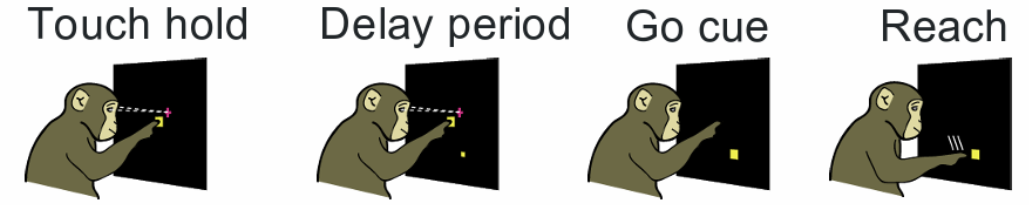

### Lectura de datos, preprocesamiento, y definición de funciones básicas

In [3]:
with open('datos_disparos_mono_tp2.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times'] #shape = 1127 episodios, 190 neuronas, nro de disparos (variable).
                                                                      #Recomendamos mirar len(spike_times), len(spike_times[n]), etc. para entender bien los datos

with open('metadata_mono_tp2.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # tiempos de aparición del target para cada episodio
    time_go_cue = metadata['time_go_cue'] # tiempo de señal de GO (comienzo del movimiento) para cada episodio
    time_target_acquired = metadata['time_target_acquired'] # tiempo en que el objetivo fue tocado para cada episodio
    trial_reach_target = metadata['trial_reach_target'] # índice de a que target tenía que ir para cada episodio (0 a 7)
    target_locations = metadata['target_locations'] #  posición x,y de cada target
    target_angles = metadata['target_angles'] # ángulo de cada target


In [4]:
# Notar que hay dos duraciones de periodo de planificación
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005], dtype=int64)

In [5]:
spike_times.shape
spike_times[0][0]

array([549.51355, 595.64166, 669.74585], dtype=float32)

In [89]:
def extract_plan_spikes(window_length=None,
                        start_offset=None,
                        spike_times=spike_times):
    # Devuelve una matriz de conteos de disparos en la ventana de planificación
    # - La ventana de planificación default está definida como el tiempo
    #   entre time_touch_held y time_go_cue para cada episodio.
    #   NOTA: no todos los episodios tienen la misma duración!
    # - Si se especifica una "window_length" (longitud de ventana), devuelve el número
    #   de disparos en la ventana para esa duración. Retorna -1 si el periodo de planificación
    #   es demasiado corto para la ventana (ej. si window_length=1000 pero el periodo de
    #   planificación era 755ms)
    # - Si se especifica un "start_offset", retorna el número de disparos en la ventana
    #   que empieza "start_offset" ms después de time_touch_held (y usa time_go_cue o la
    #   window_length opcional para determinar el final de la ventana). Si start_offset
    #   es tan grande que se extiende más que time_go_cue, retorna -1

    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held

    plan_spikes = []
    for tx, trialSpikes in enumerate(spike_times):# Para cada uno de los episodios
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]

        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el comienzo (trial_starts) o que el final del periodo de planificación (time_go_cue)")
                # plan_spikes.append(-np.ones(len(trialSpikes)))
        else:
            plan_spikes.append( # contamos cuantos disparos hubo en esa ventana para cada neurona!
                        np.array(
                        [np.sum((st > trial_starts[tx]) & (st < trial_end)) 
                        for st in trialSpikes] ))
    return np.array(plan_spikes) # debería ser de 1127 x 190 (nro de episodios x nro de neuronas)

Separemos los episodios en set de entrenamiento y testeo

In [65]:
def get_trial_sets_w_time(trial_time, n_of_each, trial_reach_target):
    short_trials = (time_go_cue - time_touch_held) == trial_time # array booleano de longitud 1127 con todos los episodios de duración 755ms en 1 y el resto en 0

    training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
    test_trials = [] # todos los que sobran
    for c in range(8): # targets del 0 al 7
        target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze()
        # seleccionar n_of_each episodios al azar (por cada dirección)
        random_training_trials = np.random.choice(target_trials, n_of_each, replace=False)
        training_trials.append(random_training_trials)
        remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)
        # los que sobran, al testing
        test_trials.extend(remaining_test_trials)
    return training_trials, test_trials

In [9]:
# Calcular el nro promedio de disparos por neurona y target
# Representa las medias de una distribución de Poisson 190-dimensional para cada una de las direcciones
def get_mean_spike_counts(training_trials, plan_spikes):
    num_neurons = plan_spikes.shape[1]
    mean_spike_counts = np.zeros((num_neurons, 8)) # Notar que las dimensiones son 190 neuronas x 8 direcciones
    for c in range(8):
        mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
    return mean_spike_counts

In [10]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01):
    # asume mu es dimensión (N,) y x es (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps # setea un promedio de disparos muy bajitos para los que daban 0 para evitar que tenga probabilidad 0
    return np.sum(x * np.log(mu2) - mu2, axis=1)

In [11]:
# Calcula la probabilidad para cada target y cada episodio
def get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes):
    poisson_likelihood = np.zeros((len(test_trials), 8))
    for c in range(8):
        m = mean_spike_counts[:,c]
        poisson_likelihood[:,c] = \
            multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])
    return poisson_likelihood

In [18]:
def decode_targets(test_trials, poisson_likelihood):
    correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
    decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!
    return correct_targets, decoded_targets

#### SIMULACIÓN BASE, SIN DELAY, SIN VENTANA, Y CON TRIAL TIME DE 755

In [67]:
# Seleccionar ventanas
plan_spikes = extract_plan_spikes(window_length=None, start_offset=None)
# Armar seleccionar los sets de entrenamiento y testeo al azar
training_trials, test_trials = get_trial_sets_w_time(755, n_of_each=25, trial_reach_target=trial_reach_target)
# Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
# Calcular las verosimilitudes para cada target
poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
# Decodificar eligiendo cual es el objetivo más probable
correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)

print(f'Porcentaje correcto: {np.mean(correct_targets==decoded_targets):.3f}')
print(f'({len(test_trials)} episodios de testeo)')

Porcentaje correcto: 0.940
(364 episodios de testeo)


---
## Ejercicio 1
#### a) Utilizar una ventana de 750 ms
Primero, modificamos la función que separa training de testing para que abarque episodios largos y cortos

In [69]:
def get_trial_sets(n_of_each, trial_reach_target):
    training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
    test_trials = [] # todos los que sobran
    for c in range(8): # targets del 0 al 7
        target_trials = np.argwhere((trial_reach_target==c)).squeeze()
        # seleccionar n_of_each episodios al azar (por cada dirección)
        random_training_trials = np.random.choice(target_trials, n_of_each, replace=False)
        training_trials.append(random_training_trials)
        remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)
        # los que sobran, al testing
        test_trials.extend(remaining_test_trials)
    return training_trials, test_trials

Ajustamos el modelo

In [70]:
# SIMULACIÓN 1A, SIN DELAY, VENTANA DE 750, SIN PARAMETRO TRIAL TIME
plan_spikes = extract_plan_spikes(window_length=750, start_offset=None)
training_trials, test_trials = get_trial_sets(25, trial_reach_target)
mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
print(f'Porcentaje correcto: {np.mean(correct_targets==decoded_targets):.3f}')
print(f'({len(test_trials)} episodios de testeo)')

Porcentaje correcto: 0.907
(927 episodios de testeo)


#### b) Rendimiento en función de longitud de la ventana de planificación
Primero, vemos cuánto miden los tiempos de planificación máximo y mínimo, para poder así tener un criterio sobre qué anchos de ventana tomar

In [60]:
t_plan = time_go_cue - time_touch_held
t_min, t_max = t_plan.min(), t_plan.max()
print(f"{t_min=}, {t_max=}")

t_min=755, t_max=1005


Esto nos invita a probar valores de ancho de ventana entre t_min//3 y t_min

In [61]:
def multitest_various_windows(widths, offsets, n_test=50) -> np.ndarray:
    """
    widths/offets: widths/offets to iterate through
    n_test: number of simulations for every value
    
    return: decode_perf, np.array of shape (len(values), n_test) with the performance for each sim
    """

    decode_perf = []
    for width, offset in zip(widths, offsets):
        # Select windows
        plan_spikes = extract_plan_spikes(window_length=width, start_offset=offset)
        decode_perf.append([])

        # Build training/testing sets and run multiple times
        for i in range(n_test):
            training_trials, test_trials = get_trial_sets(25, trial_reach_target)
            mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
            poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
            correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
            # Store percentage performance
            decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

    decode_perf = np.array(decode_perf) # convertir a numpy array
    return decode_perf

In [62]:
anchos_ventana = np.arange(200, t_min, 50)
offsets = [None]*len(anchos_ventana)
decode_perf_anchos = multitest_various_windows(anchos_ventana, offsets,50)

Ahora, ploteamos los resultados usando pandas y seaborn

C:\Users\gonza\AppData\Local\Temp\ipykernel_16672\1030687738.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=anchos_ventana)


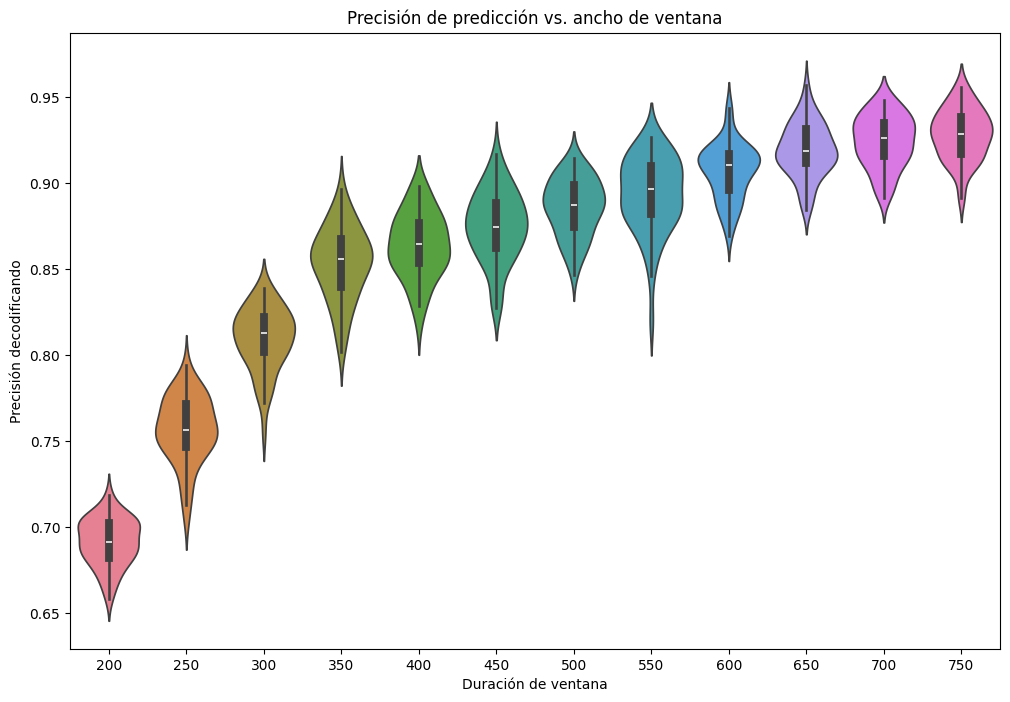

In [140]:
fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(decode_perf_anchos.T))
ax.set(xlabel='Duración de ventana', ylabel='Precisión decodificando')
ax.set(xticklabels=anchos_ventana)
ax.set(title='Precisión de predicción vs. ancho de ventana')
plt.show()


En principio, con ventanas mayores a 500 ms se empiezan a obtener resultados con precisión mayor al 90%

### c) Análisis de la injerencia del offset


In [64]:
offsets = np.arange(0, 500, 50)
widths = [250]*len(anchos_ventana)
decode_perf_offsets = multitest_various_windows(widths, offsets,50)

C:\Users\gonza\AppData\Local\Temp\ipykernel_16672\107998271.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=offsets)


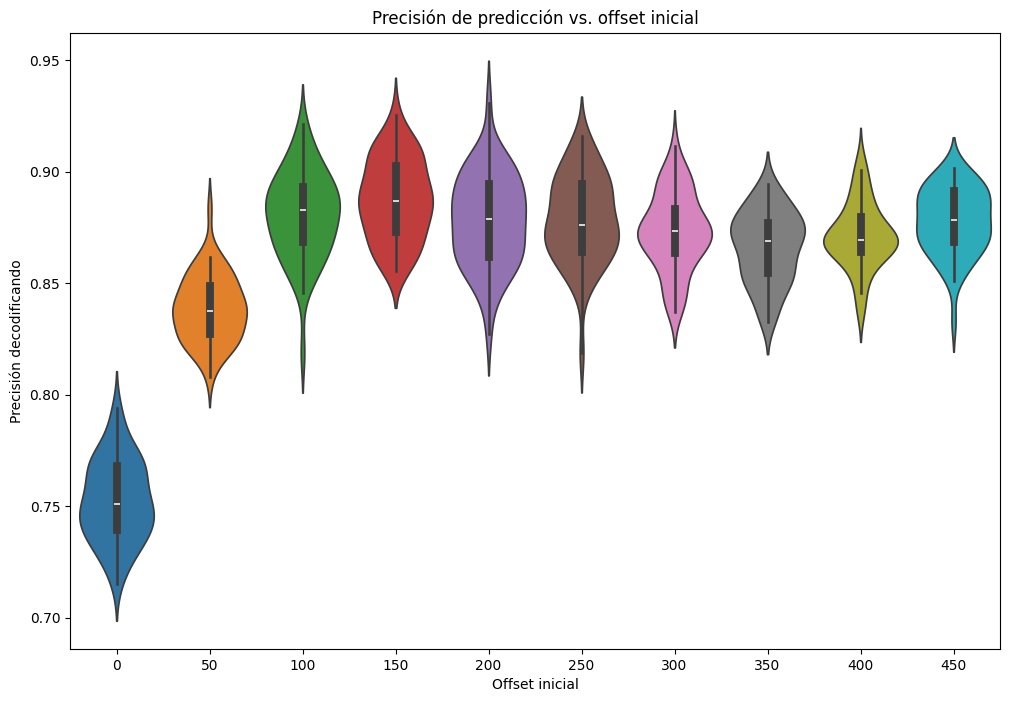

In [141]:
fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(decode_perf_offsets.T))
ax.set(xlabel='Offset inicial', ylabel='Precisión decodificando')
ax.set(xticklabels=offsets)
ax.set(title='Precisión de predicción vs. offset inicial')
plt.show()

Podemos inferir que el momento clave ocurre entre los 50 y los 100 ms

## Ejercicio 2
#### a) ¿Cómo afecta el rendimiento la cantidad de neuronas que puedo medir?
Primero, creamos la función para seleccionar neuronas, y reducimos la matriz de spikes

In [75]:
def get_reduced_spike_times(n_neurons: int, spike_times=spike_times):
    """
    n_neurons: amount of neurons to keep

    returns: a reduced version of spike times with only 'n_neurons' columns
    """
    og_idxs = np.arange(spike_times.shape[1])
    new_idxs = np.random.choice(og_idxs, n_neurons, replace=False)
    return spike_times[:, new_idxs]

In [76]:
red_spike_times = get_reduced_spike_times(10, spike_times)
red_spike_times.shape

(1127, 10)

Luego, modificamos nuestra función de multitest para que trabaje con varias cantidades de neuronas

In [94]:
def multitest_various_ncounts(width: int, 
                              offset: int, 
                              neuron_counts: list[int], 
                              n_test: int=50) -> np.ndarray:
    """
    width/offet: width/offet for the plan spikes (same for each run)
    neuron_counts: list of ints indicating the amount of neurons to considerr
    n_test: number of simulations for every value of neuron count
    
    return: decode_perf, np.array of shape (len(values), n_test) with the performance for each sim
    """

    decode_perf = []
    for n_neurons in neuron_counts:
        # Reduce the spike time matrix
        red_spike_times = get_reduced_spike_times(n_neurons, spike_times)
        
        # Select windows using only the selected neurons
        plan_spikes = extract_plan_spikes(window_length=width, start_offset=offset, 
                                          spike_times=red_spike_times)
        decode_perf.append([])

        # Build training/testing sets and run multiple times
        for i in range(n_test):
            training_trials, test_trials = get_trial_sets(25, trial_reach_target)
            mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
            poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
            correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
            # Store percentage performance
            decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

    decode_perf = np.array(decode_perf) # convertir a numpy array
    return decode_perf

Evaluamos los resultados para [30, 60, 90, 120, 150] neuronas

In [95]:
n_counts = [30, 60, 90, 120, 150]
perf_n_counts = multitest_various_ncounts(250, 100, neuron_counts=n_counts, n_test=25)

C:\Users\gonza\AppData\Local\Temp\ipykernel_16672\411132228.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=n_counts)


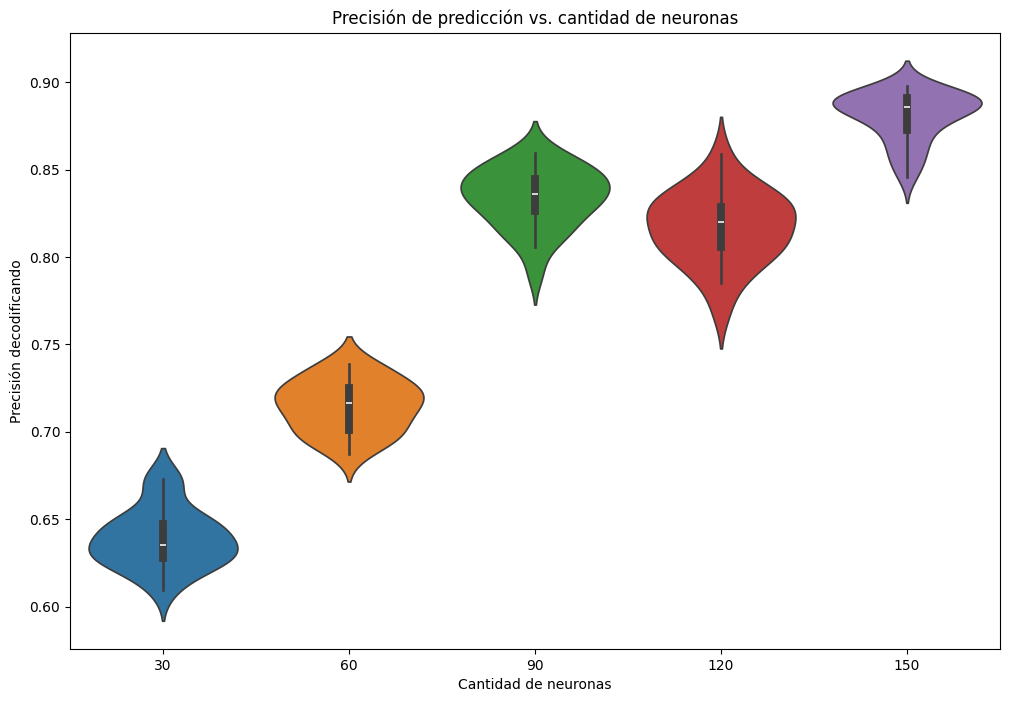

In [142]:
fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(perf_n_counts.T))
ax.set(xlabel='Cantidad de neuronas', ylabel='Precisión decodificando')
ax.set(xticklabels=n_counts)
ax.set(title='Precisión de predicción vs. cantidad de neuronas')
plt.show()

Aparentemente, a partir de 90 neuronas tenemos una buena capacidad de predicción.

#### b) ¿Cómo afecta el rendimiento tomar...?
- Las 30 neuronas más activas
- Las 30 neuronas menos activas
- 30 neuronas al azar

Para las 30 neuronas random, utilizamos la función previamente definida

In [126]:
rand_30_spike_times = get_reduced_spike_times(30, spike_times)
rand_30_spike_times.shape

(1127, 30)


Para seleccionar las 30 neuronas más/menos activas en promedio, ordenamos la matriz de spike times por la media de sus columnas, y nos quedamos con las primeras 30 de ellas

In [127]:
def sort_by_mean(X: np.ndarray) -> np.ndarray:
    """
    X: generic 2D numpy array

    returns a version of X sorted by its row average for each column
    """
    X_copy = X.copy()
    X_mean = np.zeros((X_copy.shape))
    for i in range(X_copy.shape[0]):     # recordemos que cada X[i, j] es un array de por si!
        for j in range(X_copy.shape[1]):
            X_copy[i, j] = np.mean(X[i, j])  
    X_mean = X_copy.mean(axis=0)
    col_indeces = X_mean.argsort()
    return X[:, col_indeces]

In [128]:
spike_times_sorted = sort_by_mean(spike_times)
top_30_spike_times = spike_times_sorted[:, :30]
bot_30_spike_times = spike_times_sorted[:, -30:]
top_30_spike_times.shape

c:\Users\gonza\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gonza\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


(1127, 30)

Nuevamente, modificamos la funcion de multitest para que pueda trabajar con varios subsets de la data original

In [124]:
def multitest_various_subsets(width: int, 
                              offset: int, 
                              spike_times_list: list[np.ndarray], 
                              n_test: int=50) -> np.ndarray:
    """
    width/offet: width/offet for the plan spikes (same for each run)
    spike_times_list: list of spike time matrices to consider, with varying data (chosen neurons) but same shape
    n_test: number of simulations for every value of neuron count
    
    return: decode_perf, np.array of shape (len(values), n_test) with the performance for each sim
    """

    decode_perf = []
    for red_spike_times in spike_times_list:
        # Select windows using only the selected neurons
        plan_spikes = extract_plan_spikes(window_length=width, start_offset=offset, 
                                          spike_times=red_spike_times)
        decode_perf.append([])

        # Build training/testing sets and run multiple times
        for i in range(n_test):
            training_trials, test_trials = get_trial_sets(25, trial_reach_target)
            mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
            poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
            correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
            # Store percentage performance
            decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

    decode_perf = np.array(decode_perf) # convertir a numpy array
    return decode_perf

In [129]:
spike_times_list = [top_30_spike_times, bot_30_spike_times, rand_30_spike_times]
perf_TBR = multitest_various_subsets(250, 100, spike_times_list, n_test=25)

C:\Users\gonza\AppData\Local\Temp\ipykernel_16672\427243636.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['top 30', 'bot 30', 'random'])


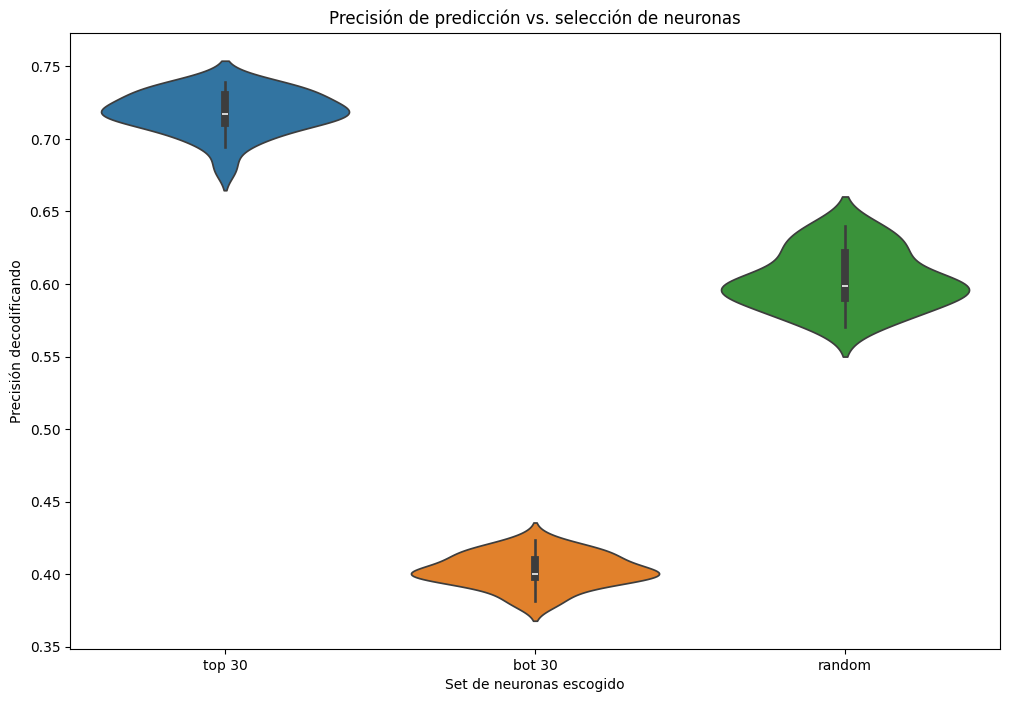

In [148]:
fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(perf_TBR.T))
ax.set(xlabel='Set de neuronas escogido', ylabel='Precisión decodificando')
ax.set(xticklabels=['top 30', 'bot 30', 'random'])
ax.set(title='Precisión de predicción vs. selección de neuronas')
plt.show()

Para evaluar cómo varían los resultados para una distinta selección de neuronas aleatorias, vamos a realizar múltiples experimentos de muestro aleatorio 

In [149]:
rand_30_list = []
for i in range(10):
    new_rand_30 = get_reduced_spike_times(30, spike_times)
    rand_30_list.append(new_rand_30)
perf_random = multitest_various_subsets(250, 100, rand_30_list, n_test=25)

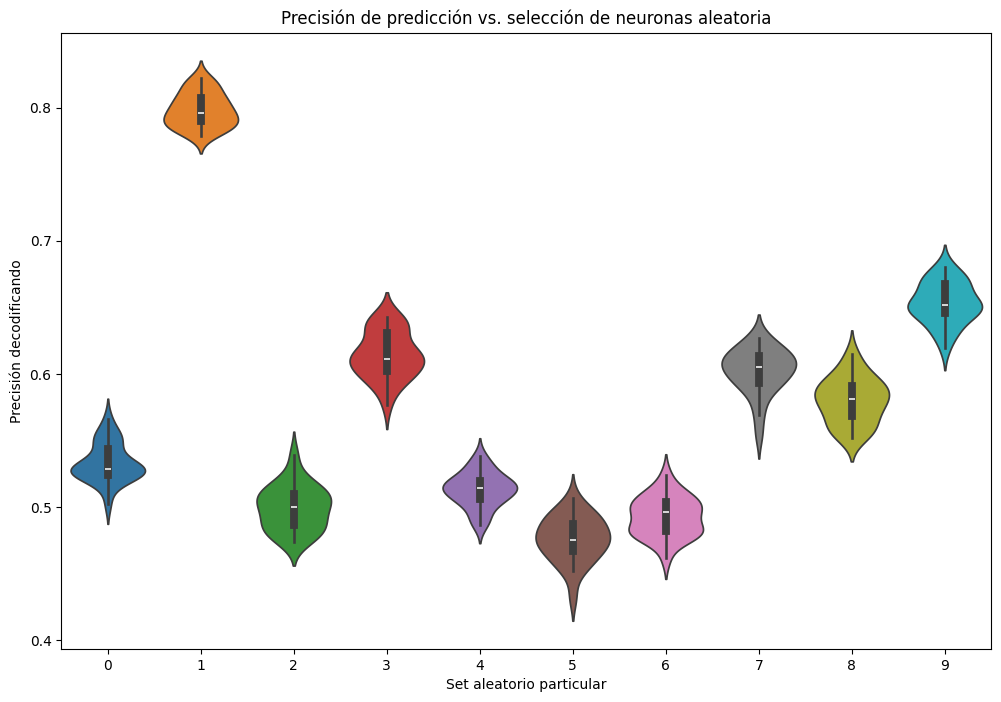

In [150]:
fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(perf_random.T))
ax.set(xlabel='Set aleatorio particular', ylabel='Precisión decodificando')
ax.set(title='Precisión de predicción vs. selección de neuronas aleatoria')
plt.show()

## Ejercicio 3
#### a) ¿Cómo afecta el rendimiento la cantidad de datos de entrenamiento?
Nuevamente, definimos una nueva función de multitest que itere sobre distintas condiciones de simulación

In [151]:
def multitest_various_training_sizes(width: int, 
                                     offset: int, 
                                     training_test_sizes: list[int], 
                                     n_test: int=50) -> np.ndarray:
    """
    width/offet: width/offet for the plan spikes (same for each run)
    training_test_sizes: list of "n_per_each" arguments for the trial set getter function, to iterate through
    n_test: number of simulations for every value of neuron count
    
    return: decode_perf, np.array of shape (len(values), n_test) with the performance for each sim
    """

    decode_perf = []
    for n_of_each in training_test_sizes:
        # Select windows using only the selected neurons
        plan_spikes = extract_plan_spikes(window_length=width, start_offset=offset)
        decode_perf.append([])

        # Build training/testing sets and run multiple times
        for i in range(n_test):
            training_trials, test_trials = get_trial_sets(n_of_each, trial_reach_target)
            mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
            poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
            correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
            # Store percentage performance
            decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

    decode_perf = np.array(decode_perf) # convertir a numpy array
    return decode_perf

Finalmente, lo testeamos para [5, 10, 15, 20, 25, 30, 35, 40] muetras de cada target

In [152]:
training_test_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
perf_train_size = multitest_various_training_sizes(250, 100, training_test_sizes, n_test=25)

C:\Users\gonza\AppData\Local\Temp\ipykernel_16672\1349790753.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=training_test_sizes)


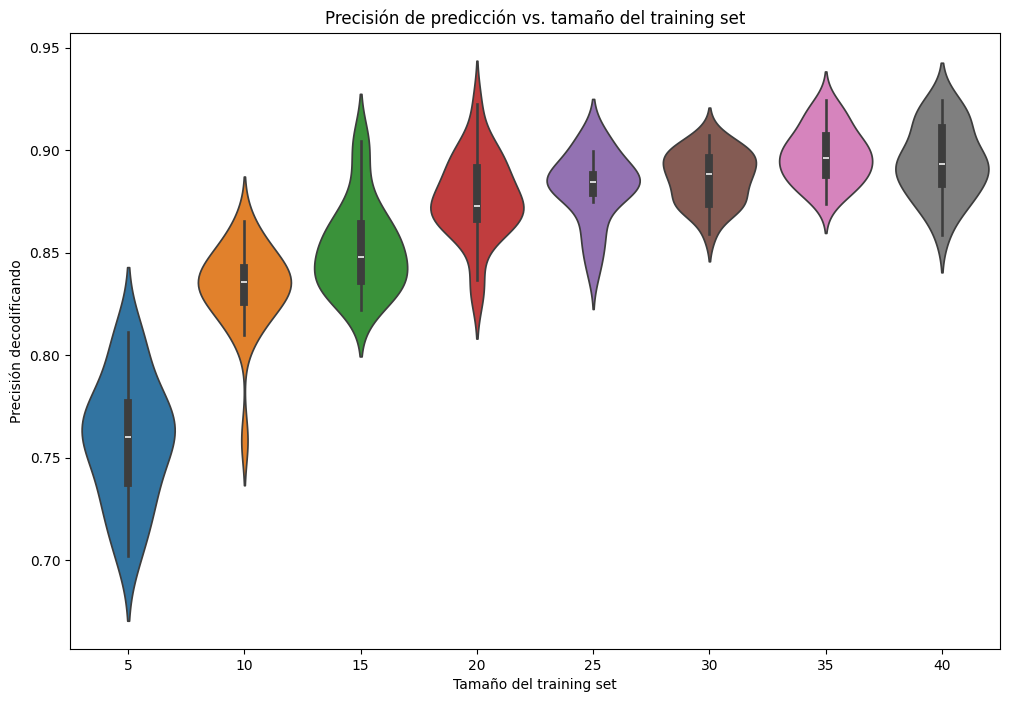

In [153]:
fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(perf_train_size.T))
ax.set(xlabel='Tamaño del training set', ylabel='Precisión decodificando')
ax.set(title='Precisión de predicción vs. tamaño del training set')
ax.set(xticklabels=training_test_sizes)
plt.show()

Con un training set de entre 20 y 25 muestras por dirección pareciera ser suficiente